# JT4G detection algorithm for DSLWP

This notebook is a testbench of a detection algorithm for the JT4G transmissions by DSLWP. This algorithm gives accurate detections down to around -25dB SNR (9dB C/N0).

The algorithm goes as follows: first, we perform an FFT so that each tone fits a single bin (FFT resolution = JT4 baudrate). Then we compute the power in each bin. Next for each symbol, we compute the `pwr[tone1] + pwr[tone3] - pwr[tone0] - pwr[tone2]`. This is then correlated against the (bipolar) sync vector of JT4.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io.wavfile

import subprocess

# Larger figure size
fig_size = [10, 6]
plt.rcParams['figure.figsize'] = fig_size

Generate a test wav file and resample to 11025sps. For simplicity, this algorithm works on sample rates multiple of 11025.

In [2]:
snr = -25
subprocess.call(['jt4sim', 'CQ EA4GPZ IN80', 'G', '0', str(snr), '1'])
subprocess.call(['sox', '000000_0000.wav', '000000_0000_res.wav', 'rate', '11025']);

Sample rate and FFT size.

In [3]:
fs = 11025 # only multiples of 11025 supported
N = 2520 * fs // 11025

Read wav file generated above.

In [4]:
rate, x = scipy.io.wavfile.read('000000_0000_res.wav')
rate

11025

Tone spacing in bin for JT4G

In [5]:
f_shift = 72

JT4G sync vector

In [6]:
sync = 2*np.array(list(map(int,'00011000110110010100000001100000000000010110110101111101000100100111110001010001111011001000110101010101111101010110101011100101101111000011011000111011101110010001101100100011111100110000110001011011110101')), dtype='int8')-1

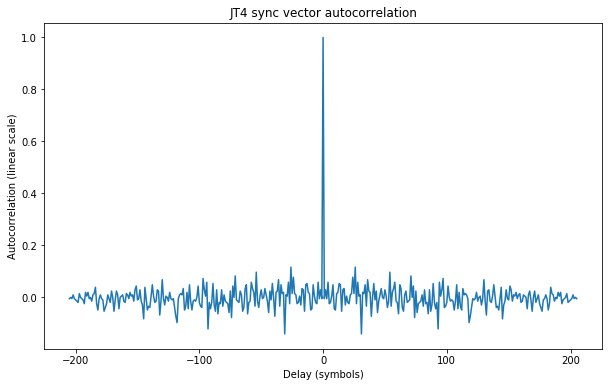

In [7]:
plt.plot(np.arange(-sync.size+1, sync.size), np.correlate(sync.astype('float'),sync.astype('float'), mode='full')/sync.size)
plt.title('JT4 sync vector autocorrelation')
plt.ylabel('Autocorrelation (linear scale)')
plt.xlabel('Delay (symbols)');

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


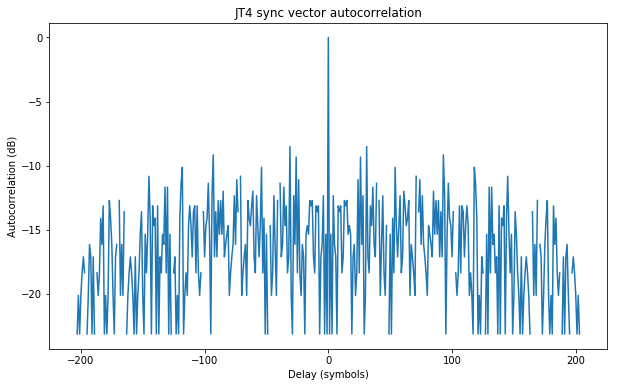

In [8]:
plt.plot(np.arange(-sync.size+1, sync.size), 10*np.log10(np.abs(np.correlate(sync.astype('float'),sync.astype('float'), mode='full')/sync.size)))
plt.title('JT4 sync vector autocorrelation')
plt.ylabel('Autocorrelation (dB)')
plt.xlabel('Delay (symbols)');

Compute the power as explained above. To get better time resolution we perform two sets of FFTs overlapping by 50%.

In [9]:
f_even = np.abs(np.fft.fftshift(np.fft.fft(x[:x.size//N*N].reshape((-1, N)), axis=1), axes=1))**2
f_even = f_even[:,f_shift:-2*f_shift] + f_even[:,3*f_shift:] - f_even[:,:-3*f_shift] - f_even[:,2*f_shift:-f_shift]
f_odd = np.abs(np.fft.fftshift(np.fft.fft(x[N//2:x.size//N*N-N//2].reshape((-1, N)), axis=1), axes = 1))**2
f_odd = f_odd[:,f_shift:-2*f_shift] + f_odd[:,3*f_shift:] - f_odd[:,:-3*f_shift] - f_odd[:,2*f_shift:-f_shift]

Correlate against the sync vector.

In [10]:
acq = np.empty((f_even.shape[0] + f_odd.shape[0] - 2*sync.size + 2, f_even.shape[1]))
acq[::2,:] = scipy.signal.lfilter(sync[::-1], 1, f_even, axis=0)[sync.size-1:,:]
acq[1::2,:] = scipy.signal.lfilter(sync[::-1], 1, f_odd, axis=0)[sync.size-1:,:]

Do several plots to assess performance.

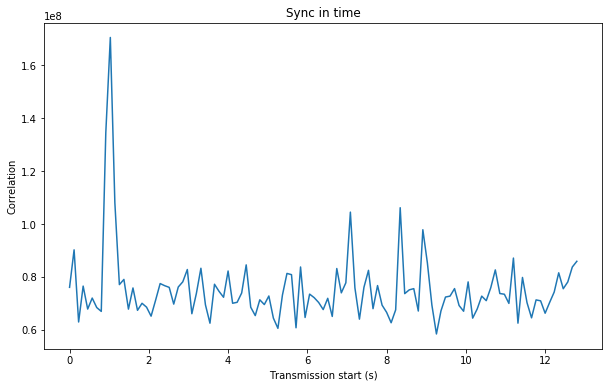

In [11]:
plt.figure(facecolor='w')
plt.plot(np.arange(acq.shape[0])/2/4.375, np.max(acq, axis=1))
plt.title('Sync in time')
plt.xlabel('Transmission start (s)')
plt.ylabel('Correlation');

In [12]:
tsync = np.argmax(np.max(acq, axis=1))

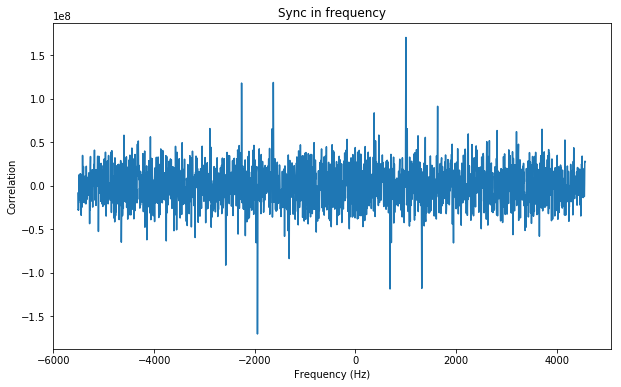

In [13]:
fs = np.arange(-N//2, -N//2 + acq.shape[1])*4.375
plt.figure(facecolor='w')
plt.plot(fs, acq[tsync,:])
plt.title('Sync in frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Correlation');

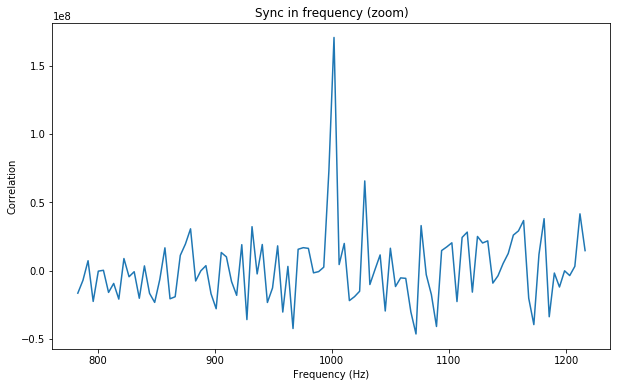

In [14]:
fsync = np.argmax(acq[tsync,:])
plt.figure(facecolor='w')
plt.plot(fs[fsync-50:fsync+50], acq[tsync,fsync-50:fsync+50])
plt.title('Sync in frequency (zoom)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Correlation');